# DBSCAN Clustering search

In [1]:
# import
import sys
sys.path.append('../')

import logging
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.testing import data_path
from scipy.ndimage import label

from visualization_utils import show, show_slices, show_cluster_centers, show_clusters, show_only_clusters
from tissue_clustering import Tissues
from loss import loss_fct

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [2]:
mri_1_label = nib.load('../MRI/Labels/final/LabelsDani.nii')
mri_1_label_data = mri_1_label.get_fdata()
mri_1_label_data.shape

(606, 864, 61)

In [3]:
tissues = { "bones": 20,
            "tendins": 2,
            "ulnar": 3,}

In [4]:
tissuesClass = Tissues(tissues_dict=tissues)
tissuesClass.get_tissues()

{'bones': 20, 'tendins': 2, 'ulnar': 3}

DBSCAN might be a better clustering technique that offers more flexibility. In this script we are going to analyze this and similar clustering algorithms and their performance on our loss function

In [5]:
from sklearn.cluster import DBSCAN

def find_DBSCAN_clusters(label: int, slice: np.array, eps: float, min_samples: int) -> None:
        
    # binary filter for the label
    binary_mask = (slice == label)

    # Check if there are tissues with given label
    if np.all(binary_mask == False):
        print("No tissues to cluster. Please set values using set_values method.")
        return []
    
    # find label positions, upon which clustering wil be defined
    label_positions = np.array(list(zip(*np.where(binary_mask))))

    # define clusterer
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)

    # find cluster prediction
    labels = clusterer.fit_predict(label_positions)
    n_labels = len(np.unique(labels)) - 1 # noise cluster has label -1, we dont take it into account
    print(f"Found {n_labels} clusters")

    # Extract clusters and their centers
    cluster_data = []

    for label in range(n_labels):
        label_to_pos_array = label_positions[labels == label] # get positions of each cluster
        cluster_centers = np.mean(label_to_pos_array, axis=0) # mean of each column
        # Save both the cluster and center under the same key
        cluster_data.append({'cluster': label_to_pos_array,
                            'center': cluster_centers})

    return cluster_data

In [6]:

def DBSCAN_cluster_iter(tissues: dict, slice: np.ndarray, eps: float, min_samples: int) -> dict:
    # store clsuters of tissues in a dict
    tissues_clusters = {}
    
    for tissue in tissues:
        print(f"Finding {tissue} clusters, with value {tissues[tissue]}:")
        # find clusters for each tissue
        tissues_clusters[tissue] = (find_DBSCAN_clusters(tissues[tissue], slice, eps, min_samples))

        # print the identified clusters and their centers
        for index, data in enumerate(tissues_clusters[tissue]):
            print(f"Center of {tissue} cluster {index}: {data['center']}")
    print("---------------------------------------\n")     
    return tissues_clusters

Found 7 clusters
Found 2 clusters
Found 1 clusters


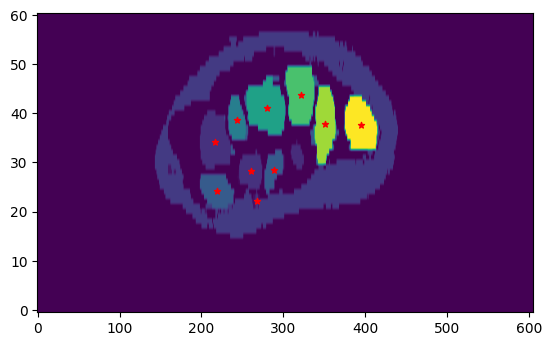

In [7]:
clusters_680 = {}
clusters_680['bones'] = find_DBSCAN_clusters(tissues['bones'], mri_1_label_data[:, 680, :], eps=2.5, min_samples=20)
clusters_680['tendins'] = find_DBSCAN_clusters(tissues['tendins'], mri_1_label_data[:, 680, :], eps=2.5, min_samples=20)
clusters_680['ulnar'] = find_DBSCAN_clusters(tissues['ulnar'], mri_1_label_data[:, 680, :], eps=2., min_samples=12)

show_clusters(clusters_680, mri_1_label_data[:, 680, :])

plt.show()

No tissues to cluster. Please set values using set_values method.
No tissues to cluster. Please set values using set_values method.
No tissues to cluster. Please set values using set_values method.
####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark loss: 3
Location loss: 1
Total loss: 1.0
#################################################### 

Loss for slice 0: 1.0
####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark loss: 3
Location loss: 1
Total loss: 1.0
#################################################### 

No tissues to cluster. Please set values using set_values method.
No tissues to cluster. Please set values using set_values method.
No tissues to cluster. Please set values using set_values method.
####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark 

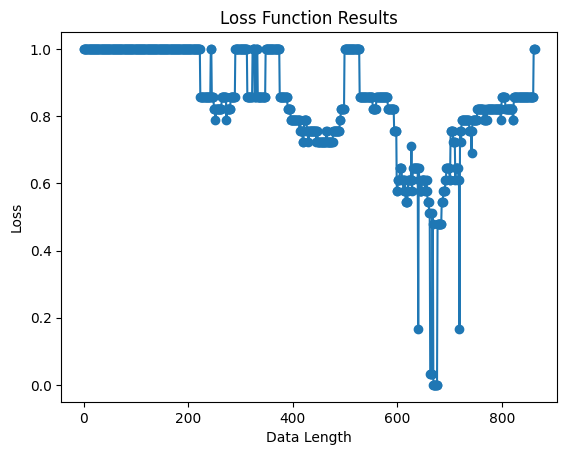

In [8]:
sweep_loss = []

for i in range(mri_1_label_data.shape[1]):
    clusters = {}
    clusters['bones'] = find_DBSCAN_clusters(tissues['bones'], mri_1_label_data[:, i, :], eps=4.1, min_samples=46)
    clusters['tendins'] = find_DBSCAN_clusters(tissues['tendins'], mri_1_label_data[:, i, :], eps=4.1, min_samples=46)
    clusters['ulnar'] = find_DBSCAN_clusters(tissues['ulnar'], mri_1_label_data[:, i, :], eps=2.5, min_samples=18)

    print(f"Loss for slice {i}: {loss_fct(clusters)}")    
    sweep_loss.append(loss_fct(clusters))

# Plot the loss results over the length of the data
plt.plot(range(len(sweep_loss)), sweep_loss, marker='o')

# Add labels and title
plt.xlabel('Data Length')
plt.ylabel('Loss')
plt.title('Loss Function Results')

# Show the plot
plt.show()

8 indices return a zero loss:  [669 670 671 672 673 674 675 676]


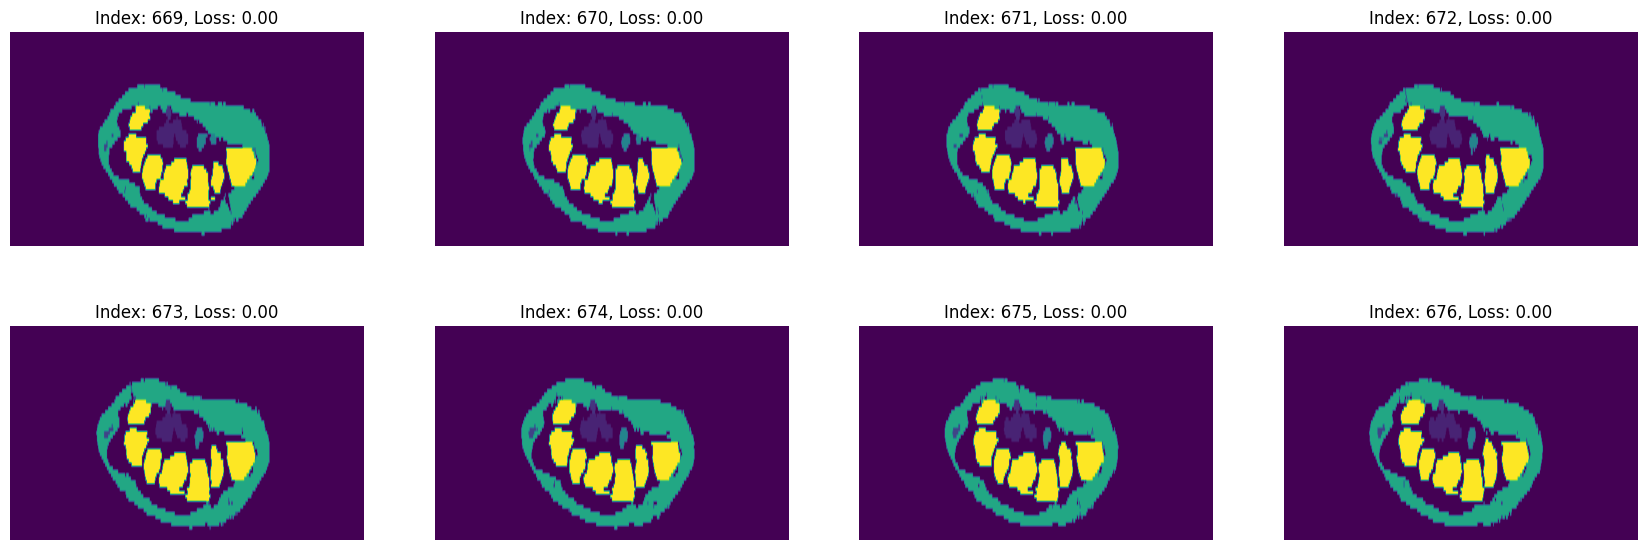

In [9]:
# Find indices where the loss is equal to 0
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

# Create a subplot for each image with 0 loss
fig, axes = plt.subplots(2, 4, figsize=(21, 7))

axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    # Plot the image
    axes[i].imshow(mri_1_label_data[:, idx, :].T, aspect=6)
    axes[i].set_title(f'Index: {idx}, Loss: {sweep_loss[idx]:.2f}')
    axes[i].axis('off')

plt.show()

In [10]:
from sklearn.cluster import HDBSCAN

def find_HDBSCAN_clusters(label: int, slice: np.array, 
                          min_cluster_size: int = 5, min_samples: int = None, 
                          eps: float = 0.0, max_cluster_size: int = None) -> None:
        
    # binary filter for the label
    binary_mask = (slice == label)

    # Check if there are tissues with given label
    if np.all(binary_mask == False):
        print("No tissues to cluster. Please set values using set_values method.")
        return []
    
    # find label positions, upon which clustering wil be defined
    label_positions = np.array(list(zip(*np.where(binary_mask))))

    # define clusterer
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                        cluster_selection_epsilon=eps, max_cluster_size=max_cluster_size, allow_single_cluster=True)

    # find cluster prediction
    labels = clusterer.fit_predict(label_positions)
    n_labels = len(np.unique(labels)) - 1 # noise cluster has label -1, we dont take it into account
    print(f"Found {n_labels} clusters")

    # Extract clusters and their centers
    cluster_data = []

    for label in range(n_labels):
        label_to_pos_array = label_positions[labels == label] # get positions of each cluster
        cluster_centers = np.mean(label_to_pos_array, axis=0) # mean of each column
        # Save both the cluster and center under the same key
        cluster_data.append({'cluster': label_to_pos_array,
                            'center': cluster_centers})

    return cluster_data

Found 5 clusters
Found 1 clusters
Found 1 clusters


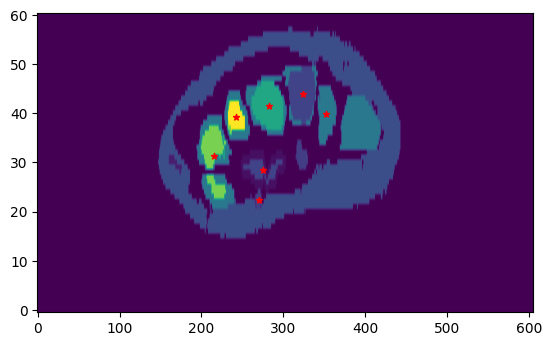

In [11]:
HDB_cluster = {}
HDB_cluster['bones'] = find_HDBSCAN_clusters(tissues['bones'], mri_1_label_data[:, 673, :], 
                                             min_cluster_size=50, max_cluster_size=350)

HDB_cluster['tendins'] = find_HDBSCAN_clusters(tissues['tendins'], mri_1_label_data[:, 673, :], 
                                             min_cluster_size=20, max_cluster_size=200)

HDB_cluster['ulnar'] = find_HDBSCAN_clusters(tissues['ulnar'], mri_1_label_data[:, 673, :], 
                                             min_cluster_size=6, max_cluster_size=30)
show_clusters(HDB_cluster, mri_1_label_data[:, 673, :])

In [12]:
# print the size of each cluster
for tissue in HDB_cluster:
    for index, data in enumerate(HDB_cluster[tissue]):
        print(f"Size of {tissue} cluster {index}: {len(data['cluster'])}")

Size of bones cluster 0: 315
Size of bones cluster 1: 155
Size of bones cluster 2: 309
Size of bones cluster 3: 255
Size of bones cluster 4: 101
Size of tendins cluster 0: 106
Size of ulnar cluster 0: 22
